In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import mnist_utils

import semisupervised_vae_lib as ss_vae_lib

# Load data

In [2]:
seed = 901

In [3]:
np.random.seed(seed)
_ = torch.manual_seed(seed)

# LOAD DATA
print('Loading data')
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample = 0.01,
                                                    propn_labeled = 0.05)

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=40,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=100,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=100,
                shuffle=False)

Loading data


In [4]:
seed = 4353

np.random.seed(seed)
_ = torch.manual_seed(seed)

for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break

for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    test_data = d
    break

In [5]:
assert np.all(data_labeled['image'].detach().numpy() <= 1)

In [6]:
assert np.all(data_labeled['image'].detach().numpy() >= 0)

In [7]:
np.min(data_labeled['image'].detach().numpy())

0.0

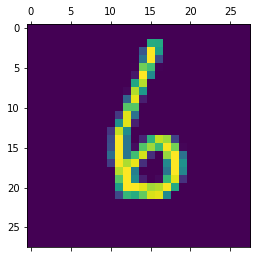

In [8]:
plt.matshow(data_labeled['image'][0, :, :])

In [9]:
slen = data_labeled['image'].shape[-1]

# Define VAE

In [13]:
latent_dim = 4
n_classes = 10

In [14]:
vae = mnist_vae_lib.get_mnist_vae(latent_dim = latent_dim, 
                    n_classes = n_classes, 
                   slen = slen)

In [15]:
# Load results

file_base = '../mnist_vae_results/mnist_vae_topk10'

# file_base = '../mnist_vae_results/mnist_vae_true_labels'

which_epoch = 'final'

enc_file = file_base + '_enc_' + which_epoch
dec_file = file_base + '_dec_' + which_epoch
classifier_file = file_base + '_classifier_' + which_epoch

# enc_file = "../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_simple_baseline_enc_final"
# dec_file = '../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_simple_baseline_dec_final'
# classifier_file = '../mnist_vae_results_aws/mnist_vae_semisuper_reinforce_simple_baseline_classifier_final'


vae.conditional_vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

vae.conditional_vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))

vae.classifier.load_state_dict(torch.load(classifier_file,
                               map_location=lambda storage, loc: storage))


vae.eval()

SemiSupervisedVAE(
  (conditional_vae): MNISTConditionalVAE(
    (encoder): MLPEncoder(
      (fc1): Linear(in_features=794, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=128, bias=True)
      (fc4): Linear(in_features=128, out_features=8, bias=True)
    )
    (decoder): MLPConditionalDecoder(
      (fc1): Linear(in_features=14, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=256, bias=True)
      (fc4): Linear(in_features=256, out_features=784, bias=True)
      (sigmoid): Sigmoid()
    )
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=256, bias=True)
    (fc4): Linear(in_features=256, out_features=10, bias=True)
    (log_softmax): LogSoftmax()
  )
)

# Check losses

In [16]:
loss_array = np.loadtxt(file_base + '_loss_array.txt')

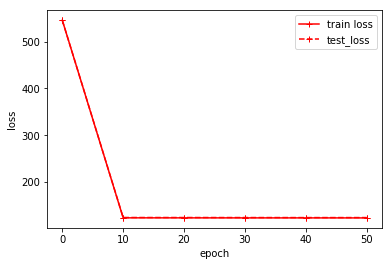

In [17]:
# plot losses
start_indx = 0

plt.plot(loss_array[0, start_indx:], loss_array[1, start_indx:], 'r-+')
plt.plot(loss_array[0, start_indx:], loss_array[2, start_indx:], 'r--+')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(('train loss', 'test_loss'))

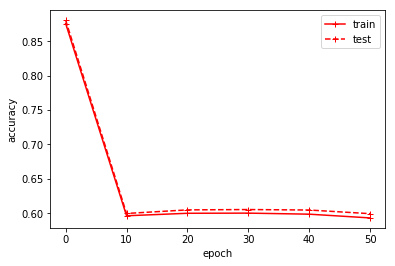

In [18]:
# plot trianing accuracy
plt.plot(loss_array[0, start_indx:], loss_array[3, start_indx:], 'r-+')
plt.plot(loss_array[0, start_indx:], loss_array[4, start_indx:], 'r--+')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(('train', 'test'))

In [19]:
batch_loss_array = np.loadtxt('../mnist_vae_results/mnist_vae_topk10_batch_loss_array.txt')
batch_loss_array2 = np.loadtxt('../mnist_vae_results/mnist_vae_topk2_batch_loss_array.txt')

Text(0,0.5,'accuracy')

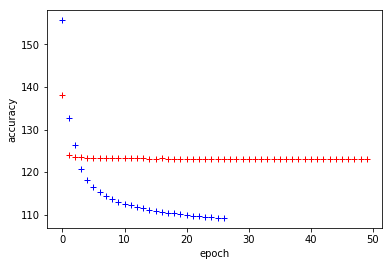

In [20]:
# plot trianing accuracy
plt.plot(batch_loss_array[1:], 'r+')
plt.plot(batch_loss_array2[1:], 'b+')

# plt.plot(loss_array[0, start_indx:], loss_array[4, start_indx:], 'r--+')

plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.legend(('train', 'test'))

In [21]:
_, loss = vae.get_semisupervised_loss(data_unlabeled['image'], data_labeled['image'], 
                                      data_labeled['label'], 0)
print(loss / data_unlabeled['image'].shape[0])

tensor(127.3263)


In [22]:
_, loss = vae.get_semisupervised_loss(test_data['image'], data_labeled['image'], data_labeled['label'], 0)
print(loss / test_data['image'].shape[0])

tensor(126.9247)


# Look at classification accuracies 

In [23]:
labeled_accuracy, labeled_wrong_images, labeled_wrong_labels = \
    ss_vae_lib.get_classification_accuracy(vae.classifier, train_loader_labeled,
                                            return_wrong_images = True, max_images = np.Inf)
    
print(labeled_accuracy)

tensor(0.8333)


In [24]:
unlabeled_accuracy, unlabeled_wrong_images, unlabeled_wrong_labels= \
    ss_vae_lib.get_classification_accuracy(vae.classifier, train_loader_unlabeled,
                                                return_wrong_images = True, 
                                                 max_images = np.Inf)
    
print(unlabeled_accuracy)

tensor(0.6649)


In [25]:
test_accuracy, test_wrong_images, test_wrong_labels = \
    ss_vae_lib.get_classification_accuracy(vae.classifier, test_loader,
                                                return_wrong_images = True, max_images = np.Inf)

print(test_accuracy)

tensor(0.5900)


In [26]:
log_q = vae.classifier(data_unlabeled['image'])

In [27]:
torch.exp(log_q)[0, :]

tensor([ 1.1680e-02,  1.3283e-08,  7.5552e-07,  2.5683e-05,  1.3347e-05,
         3.0863e-06,  2.2090e-04,  5.1651e-11,  9.8806e-01,  1.1331e-10])

# Check reconstructions

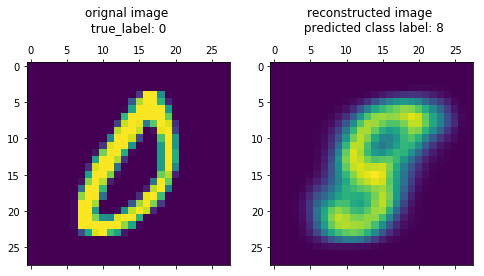

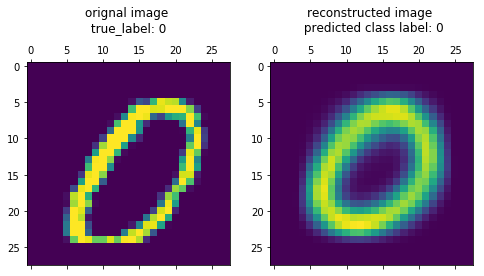

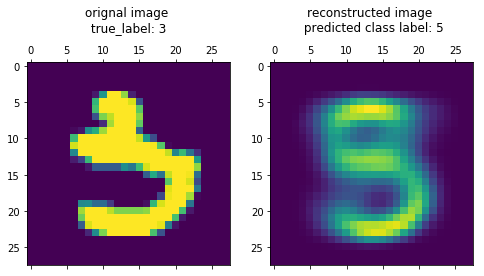

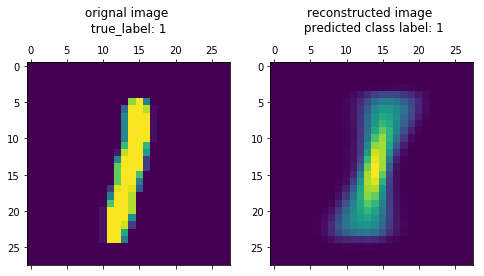

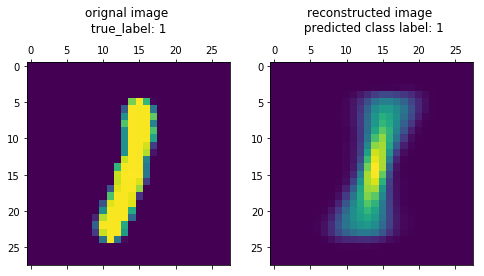

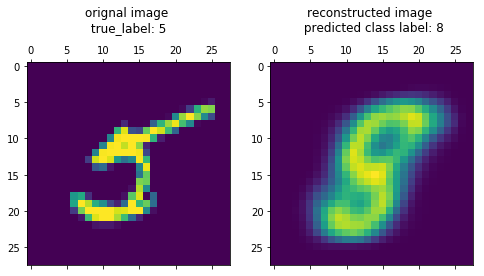

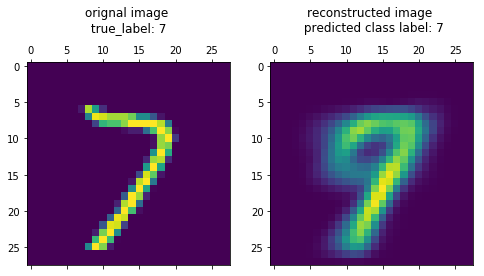

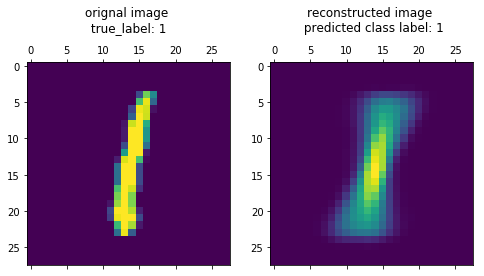

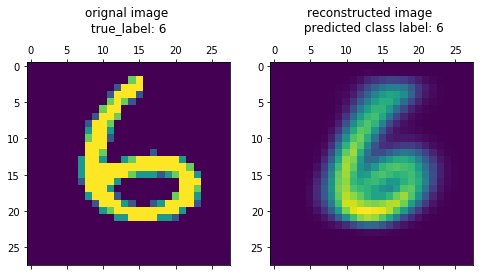

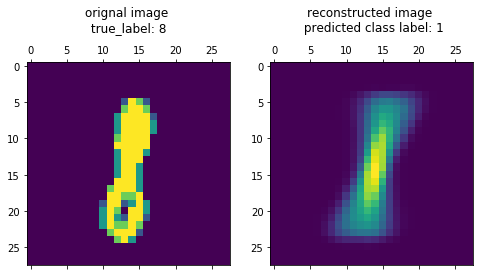

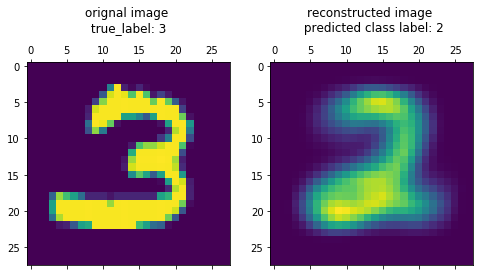

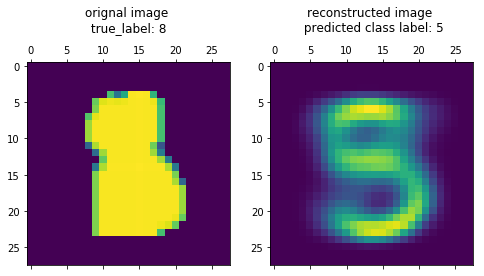

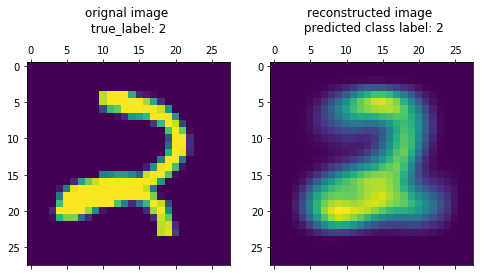

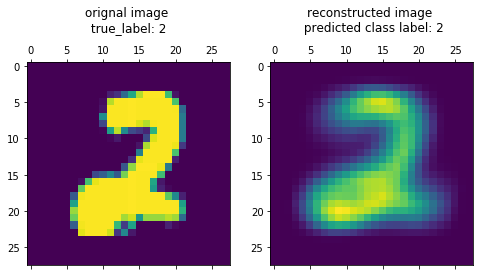

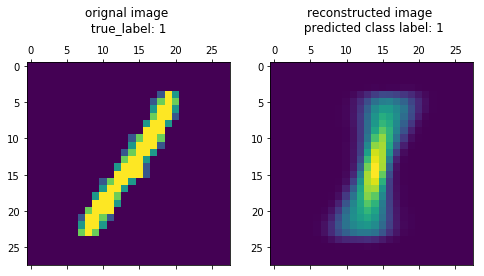

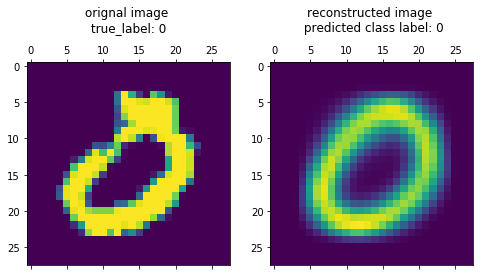

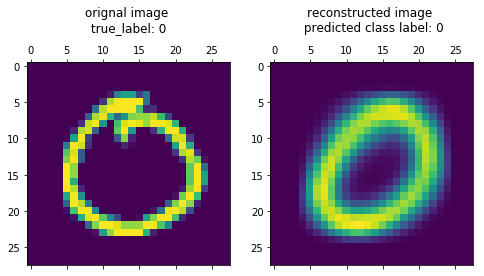

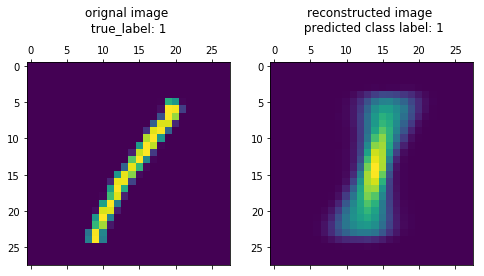

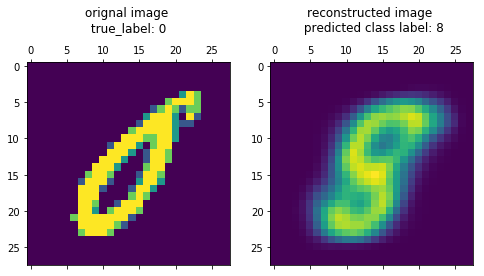

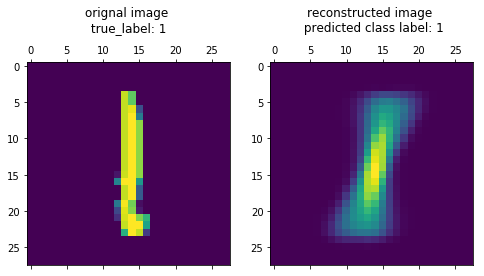

In [28]:
# Look at training images
use_true_labels = False
if use_true_labels: 
    labels=data_unlabeled['label']
else: 
    labels = None 
    
image_mu, z_ind = ss_vae_lib.get_reconstructions(vae, data_unlabeled['image'], labels = labels)

figsize = 8
for i in range(0, 20): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(data_unlabeled['image'][i, :, :])
    axarr[1].matshow(image_mu[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n true_label: {} \n'.format(data_unlabeled['label'][i]))
    axarr[1].set_title('reconstructed image \n predicted class label: {}\n'.format(z_ind[i]))

In [29]:
# Check the training images that were wrong

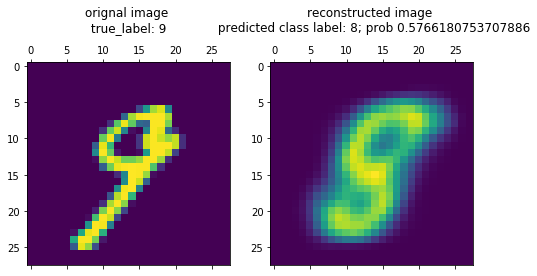

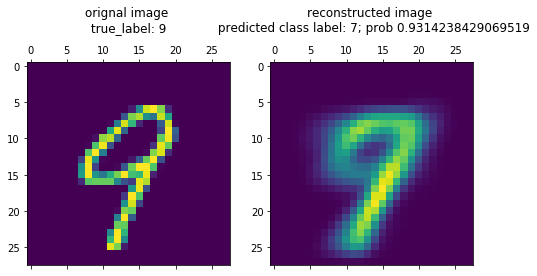

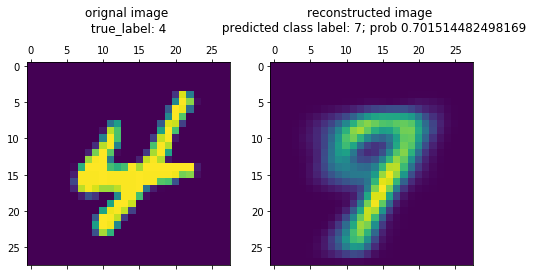

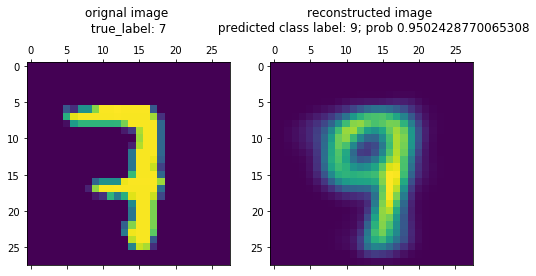

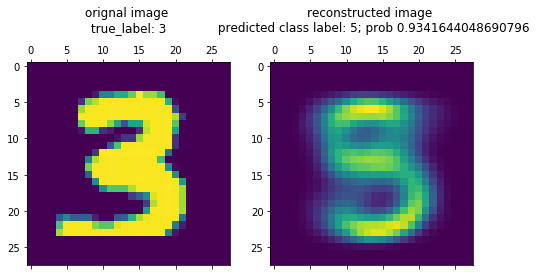

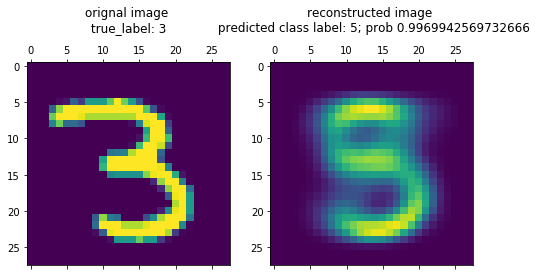

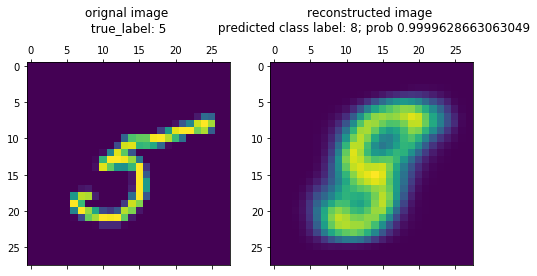

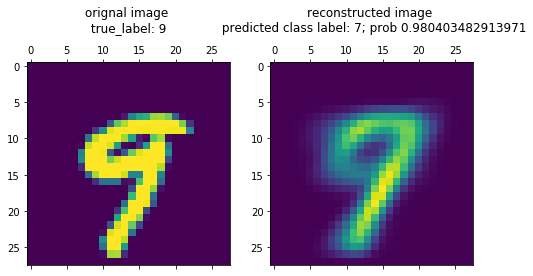

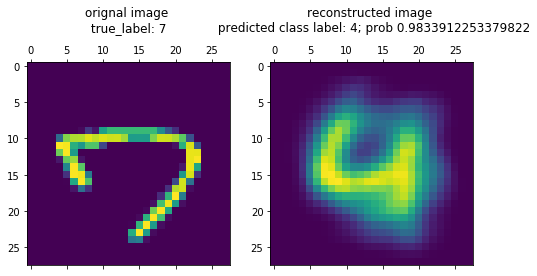

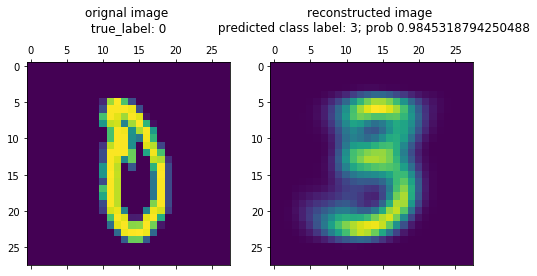

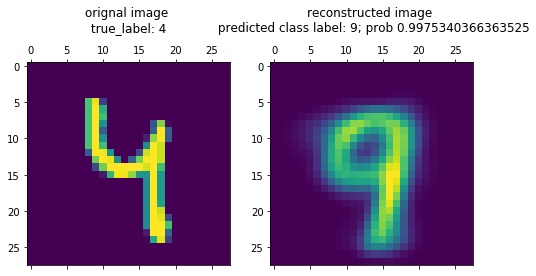

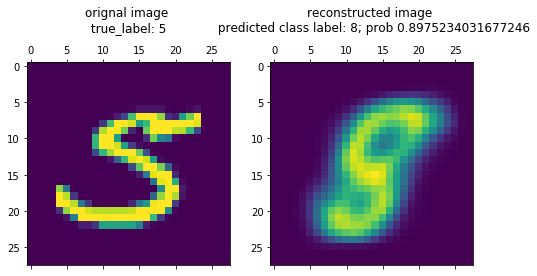

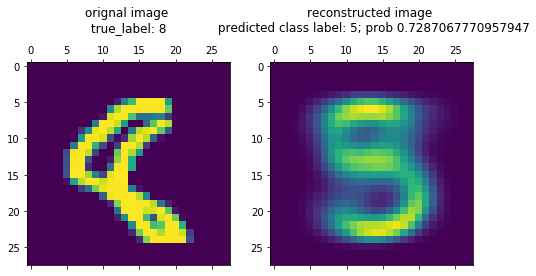

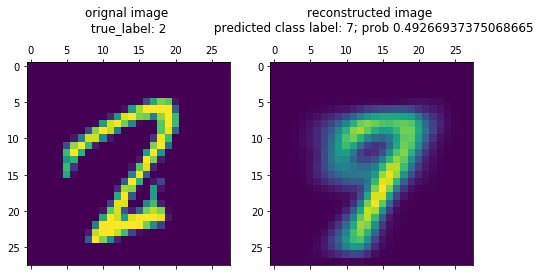

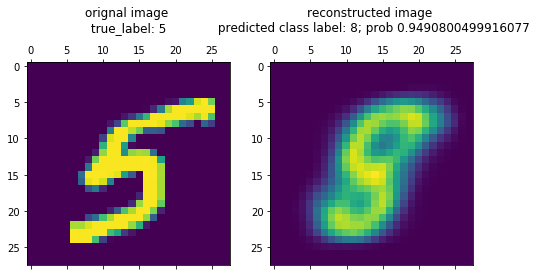

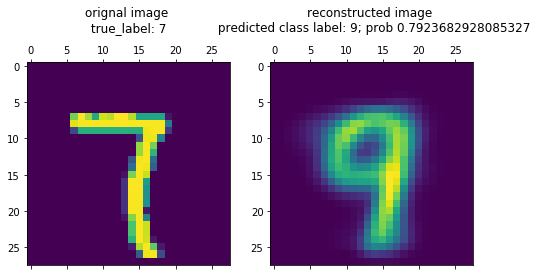

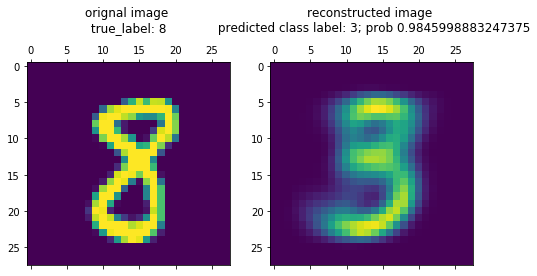

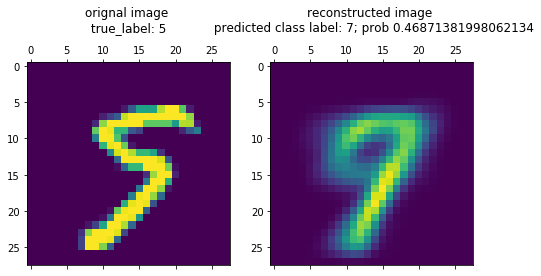

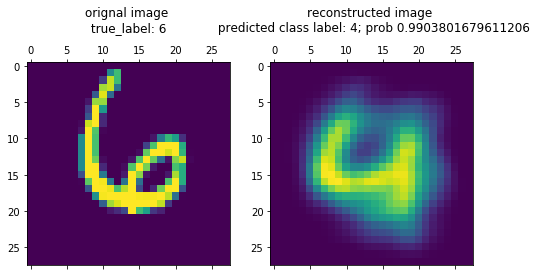

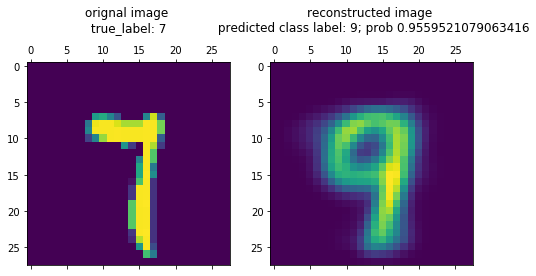

In [30]:
image_mu, z_ind = ss_vae_lib.get_reconstructions(vae, unlabeled_wrong_images)
class_weights = torch.exp(torch.max(vae.classifier(unlabeled_wrong_images), dim = 1)[0])

figsize = 8
for i in range(0, 20): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(unlabeled_wrong_images[i, :, :])
    axarr[1].matshow(image_mu[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n true_label: {} \n'.format(unlabeled_wrong_labels[i]))
    axarr[1].set_title('reconstructed image \n predicted class label: {}; prob {}\n'.format(\
                                                                z_ind[i], class_weights[i]))

In [31]:
# check a few test images 

In [32]:
class_weights = vae.classifier(test_data['image'])

z_ind = torch.argmax(class_weights, dim = 1)
z_ind_one_hot = mnist_utils.get_one_hot_encoding_from_int(z_ind, n_classes)

image_mu, z_ind = ss_vae_lib.get_reconstructions(vae, test_data['image'], labels = None)


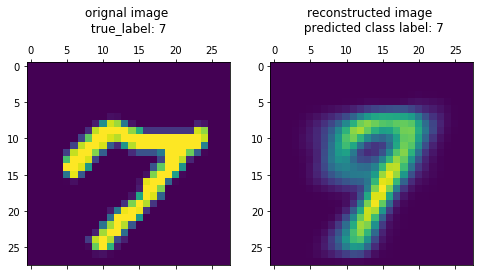

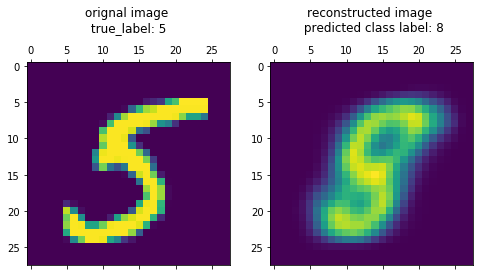

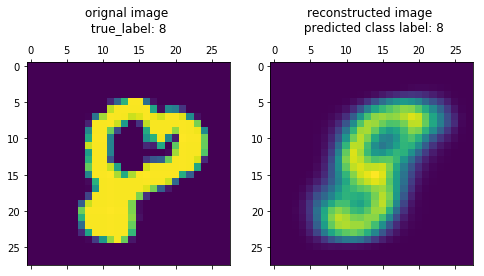

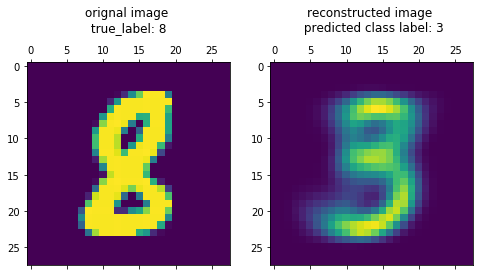

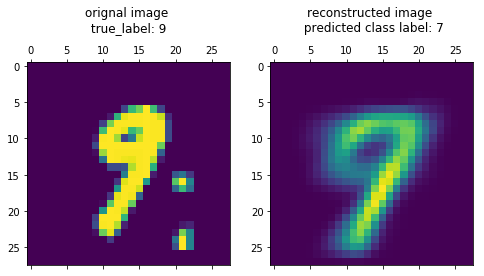

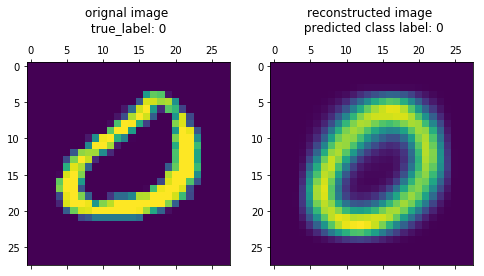

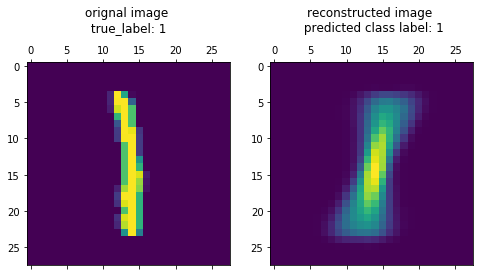

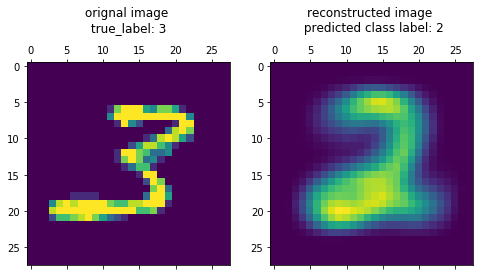

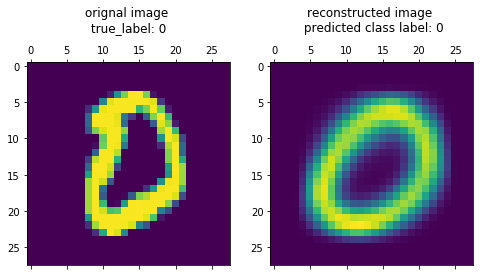

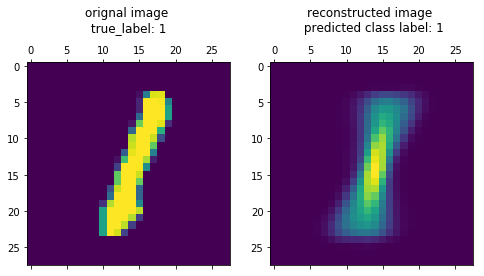

In [33]:
figsize = 8
for i in range(0, 10): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(test_data['image'][i, :, :])
    axarr[1].matshow(image_mu[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n true_label: {} \n'.format(test_data['label'][i]))
    axarr[1].set_title('reconstructed image \n predicted class label: {}\n'.format(z_ind[i]))

# check conditional generation

In [44]:
num = 10
latent_params = torch.randn((10, latent_dim)) 

digit = 7
one_hot_z = mnist_utils.get_one_hot_encoding_from_int(torch.ones(num) * digit, n_classes)
recon_mean = vae.conditional_vae.decoder(latent_params, one_hot_z)

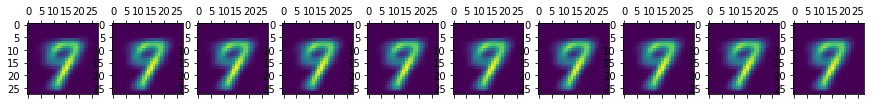

In [45]:
f, axarr = plt.subplots(1, num, figsize=(15, 15))

for i in range(0, num): 
    axarr[i].matshow(recon_mean[i, :, :].detach())


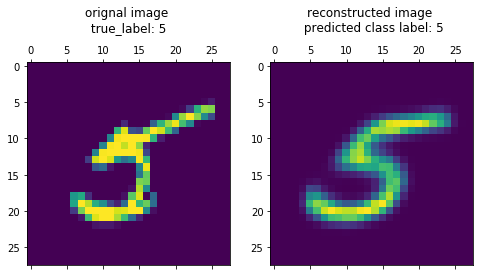

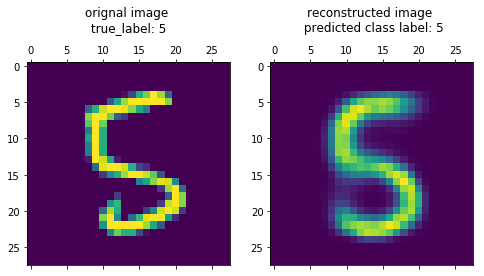

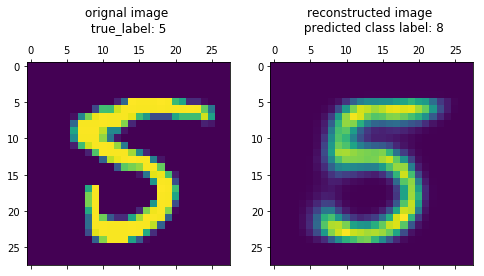

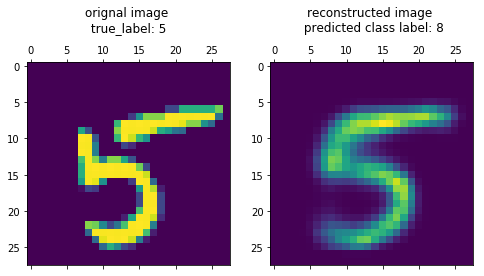

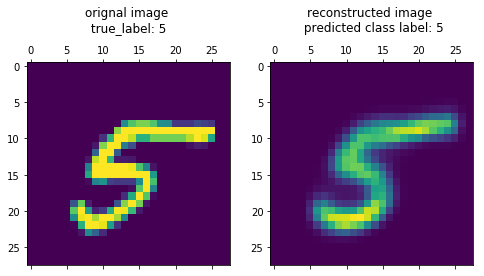

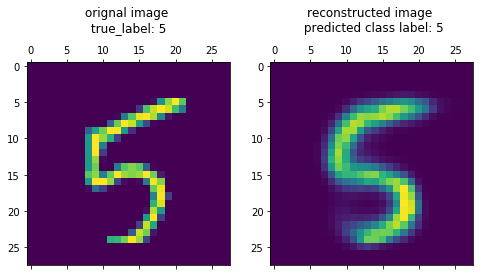

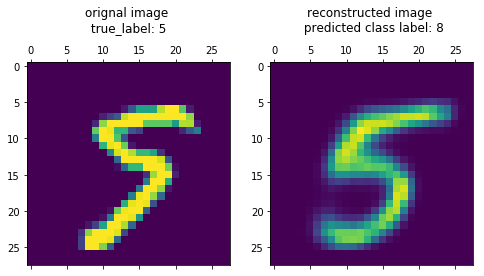

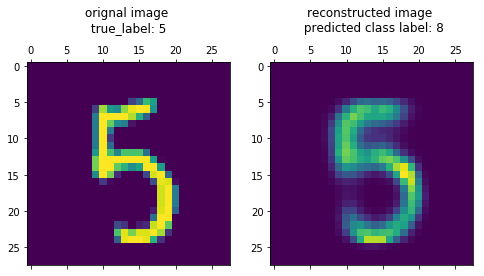

In [34]:
# labels = data_unlabeled['label']
labels = None 

image_mu, z_ind = ss_vae_lib.get_reconstructions(vae, data_unlabeled['image'], 
                                                    labels = labels)

figsize = 8
for i in range(0, 100): 
    if not (data_unlabeled['label'][i] == 5): 
        continue 
        
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(data_unlabeled['image'][i, :, :])
    axarr[1].matshow(image_mu[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n true_label: {} \n'.format(data_unlabeled['label'][i]))
    axarr[1].set_title('reconstructed image \n predicted class label: {}\n'.format(z_ind[i]))